# 5900 Capstone Time Series Model - Exponential Smoothing Model - Pivot with SafeMax

### Step 1: load packages

In [2]:
# load packages
library(ggplot2);library(ggthemes);library(gridExtra);library(dygraphs) # For plots 
library(quantmod);library(xts);library(zoo) # For converting data into xts class objects
library(fpp); library(fpp2) # Datasets from Forecasting text by Rob Hyndman
library(tseries) # for a statistical test
library(dplyr) # Data wrangling
library(caret) # Model Training
library(lubridate)

In [3]:
# Forecasting Tools
library(forecast) # Set of forecasting functions, including auto.arima

In [4]:
# Model Evaluation
# using the accuracy function in forecast package to provide model evaluation metrics, including ME, RMSE etc

### Step 2: read dataset

In [5]:
# 2019 order dataset
setwd('/Users/czw/Desktop')
order = read.csv("order19.csv") 
# pre-filtered dataset of items having price over 50
# transform the data type for order - 2019
order$Order.Qty=as.numeric(order$Order.Qty)
order$Order.Amount = as.numeric(order$Order.Amount)
order$Transaction.Date=as.Date(order$Transaction.Date, format='%m/%d/%Y')
order$Transaction.month=month(as.POSIXlt(order$Transaction.Date, format="%m/%d/%Y"))
order$Week.End.Date=as.Date(order$Week.End.Date, format='%m/%d/%Y')
order$Sub_Category_Family = as.factor(order$Sub_Category_Family)
# add a new column for unit price
order$unit_price = order$Order.Amount/order$Order.Qty 
# filter the dataset that only captures the items with unit price>$50
order = order %>%
    filter(order$unit_price>50)
head(order)

Company,Transaction.Date,Week.End.Date,Item,Item.Description,Category_Family,Category_Code,Sub_Category_Family,BRAND,Customer,...,Short.Close.Amount,Open.Qty,Open.Amount,Invoice.Qty,Invoice.Net.Amount,Invoice.Gross.Amount,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2019-01-01,2019-01-05,55411811,VIVE ELITE TS EMBRACE LINUS,Wheeled Goods,Travel Systems,Vive with Embrace,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,89.25
100,2019-01-01,2019-01-05,37112075,SURERIDE SPORT HARPER,Car Seats,Convertible,SureRide/Titan 65,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,72.00
100,2019-01-01,2019-01-05,34912204,MAESTRO SPORT WHITNEY,Car Seats,Booster,Maestro Sport,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,61.69
100,2019-01-01,2019-01-05,34812023,SONUS65 ROCCO RED,Car Seats,Convertible,Sonus,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,68.25
100,2019-01-01,2019-01-05,13812254,PIVOT XPAND STROLLER PERCHERON,Wheeled Goods,Strollers,Xpand,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,181.99
100,2019-01-01,2019-01-05,39212241,EVERYSTAGE DLX CANYONS,Car Seats,Convertible,Everystage,Evenflo,A731D,...,0,0,0,0,0,0,0,0,1,154.79


In [6]:
# 2018 order dataset
setwd('/Users/czw/Desktop')
order2=read.csv("order18.csv") 
# transform the data type for order - 2018
order2$Order.Qty=as.numeric(order2$Order.Qty)
order2$Order.Amount=as.numeric(order2$Order.Amount)
order2$Transaction.Date=as.Date(order2$Transaction.Date, format='%d-%B-%y')
order2$Transaction.month=month(as.POSIXlt(order2$Transaction.Date, format="%d-%B-%y"))
order2$Week.End.Date..EF.=as.Date(order2$Week.End.Date..EF., format='%d-%B-%y')
order2$Sub.Category = as.factor(order2$Sub.Category)
# add a new column for unit price
order2$unit_price = order2$Order.Amount/order2$Order.Qty
# filter the dataset that only captures the items with unit price>$50
order2 = order2 %>%
    filter(order2$unit_price>50)
head(order2)

Company,Transaction.Date,Week.End.Date..EF.,Item,Item.Description,Category.Family,Category,Sub.Category,Brand,Customer.ID,...,Open.Amount,Invoice.Qty,Invoice.Gross.Amount..HC.,Invoice.Net.Amount..HC.,Invoice.Gross.Amount..USD.,Invoice.Net.Amount..USD.,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2018-01-01,2018-01-06,1050500,TOP OF STAIR EXTRA TALL BOX,Gates,Wood Gates,105 Gates,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,138.73333
100,2018-01-01,2018-01-06,30512004,PROSERIES LTMX PORTLAND TWEED,Car Seats,Infant,Litemax,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,308.66667
100,2018-01-01,2018-01-06,34411927,SAFEMAX 3 IN 1 CRIMSON,Car Seats,Booster,Safemax,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,60.86667
100,2018-01-01,2018-01-06,4448100,EMBRACE WOOD & METAL GATE .COM,Gates,Metal Gates,105 Gates,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,212.66667
100,2018-01-01,2018-01-06,4449100,EMBRACE CLEAR PANEL GATE .COM,Gates,Metal Gates,448 Gates,Evenflo,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,212.66667
100,2018-01-01,2018-01-06,60511372,ZOO FRIENDS EXERSAUCER DLX,Activity,Activity Centers,Exersaucer Deluxe,Exersaucer,A731,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,1,154.88889


### Step 3: Visualize the Historical Sales

In [7]:
# Group by the Sub_Category_Family & transaction date, get the sum of order quantity 2019
# Editing whitespace out of levels
order$Sub_Category_Family = factor(trimws(order$Sub_Category_Family))
# subcategory 1: Symphony - 2019
order = order %>%
    filter(order$Sub_Category_Family == 'Pivot with SafeMax')
head(order)

Company,Transaction.Date,Week.End.Date,Item,Item.Description,Category_Family,Category_Code,Sub_Category_Family,BRAND,Customer,...,Short.Close.Amount,Open.Qty,Open.Amount,Invoice.Qty,Invoice.Net.Amount,Invoice.Gross.Amount,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2019-01-03,2019-01-05,56012217,PIVOT TS SAFEMAX DUSTY ROSE,Wheeled Goods,Travel Systems,Pivot with SafeMax,Evenflo,A731D,...,0,0,0,1,190.56,190.56,0,0,1,190.56
100,2019-01-09,2019-01-12,56012215,PIVOT TS SAFEMAX NAVY,Wheeled Goods,Travel Systems,Pivot with SafeMax,Evenflo,A731,...,0,0,0,0,0.00,0.00,0,0,1,181.49
100,2019-01-09,2019-01-12,56011993,PIVOT MOD TS SFMX ICS SNDSTNE,Wheeled Goods,Travel Systems,Pivot with SafeMax,Evenflo,A731,...,0,0,0,0,0.00,0.00,0,0,1,181.49
100,2019-01-10,2019-01-12,56012217,PIVOT TS SAFEMAX DUSTY ROSE,Wheeled Goods,Travel Systems,Pivot with SafeMax,Evenflo,A731D,...,0,0,0,1,190.56,190.56,0,0,1,190.56
100,2019-01-11,2019-01-12,56012217,PIVOT TS SAFEMAX DUSTY ROSE,Wheeled Goods,Travel Systems,Pivot with SafeMax,Evenflo,A731D,...,0,0,0,1,190.56,190.56,0,0,1,190.56
100,2019-01-11,2019-01-12,56011993,PIVOT MOD TS SFMX ICS SNDSTNE,Wheeled Goods,Travel Systems,Pivot with SafeMax,Evenflo,A731,...,0,0,0,0,0.00,0.00,0,0,1,181.49


In [8]:
# subcategory 1: Symphony - 2018
order2$Sub.Category= factor(trimws(order2$Sub.Category))
order2 = order2 %>%
    filter(order2$Sub.Category == 'Pivot with SafeMax')
head(order2)

Company,Transaction.Date,Week.End.Date..EF.,Item,Item.Description,Category.Family,Category,Sub.Category,Brand,Customer.ID,...,Open.Amount,Invoice.Qty,Invoice.Gross.Amount..HC.,Invoice.Net.Amount..HC.,Invoice.Gross.Amount..USD.,Invoice.Net.Amount..USD.,POS.Qty,POS.Amount,Transaction.month,unit_price
100,2018-02-27,2018-03-03,56011990,PIVOT MDTS G0179 SFMX CSUAlGRY,Wheeled Goods,Travel Systems,Pivot with SafeMax,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,2,92.53333
100,2018-03-02,2018-03-03,56011990,PIVOT MDTS G0179 SFMX CSUAlGRY,Wheeled Goods,Travel Systems,Pivot with SafeMax,Evenflo,A731D,...,$ -,2,$ 381,381.12,$ 381,$ 381,0,$ -,3,96.53333
100,2018-03-09,2018-03-10,56011990,PIVOT MDTS G0179 SFMX CSUAlGRY,Wheeled Goods,Travel Systems,Pivot with SafeMax,Evenflo,A731D,...,$ -,5,$ 953,952.80,$ 953,$ 953,0,$ -,3,96.53333
100,2018-03-13,2018-03-17,56011990,PIVOT MDTS G0179 SFMX CSUAlGRY,Wheeled Goods,Travel Systems,Pivot with SafeMax,Evenflo,A731D,...,$ -,2,$ 381,381.12,$ 381,$ 381,0,$ -,3,96.53333
100,2018-03-16,2018-03-17,56012217,PIVOT TS SAFEMAX DUSTY ROSE,Wheeled Goods,Travel Systems,Pivot with SafeMax,Evenflo,A731D,...,$ -,1,$ 191,190.56,$ 191,$ 191,0,$ -,3,96.53333
100,2018-03-17,2018-03-17,56012217,PIVOT TS SAFEMAX DUSTY ROSE,Wheeled Goods,Travel Systems,Pivot with SafeMax,Evenflo,A731D,...,$ -,0,$ -,0.00,$ -,$ -,0,$ -,3,96.53333


In [9]:
# Group by the Sub_Category_Family & transaction date, get the sum of order quantity 2019
days = order %>%
    group_by(Transaction.Date) %>%
    summarise(order_qty=sum(Order.Qty)) %>%
    mutate(transaction_month = month(Transaction.Date)) %>%
    mutate(transaction_year = year(Transaction.Date))
# convert numberic month to the abbreviation of month
days$transaction_month = month.abb[days$transaction_month]
head(days)

`summarise()` ungrouping output (override with `.groups` argument)



Transaction.Date,order_qty,transaction_month,transaction_year
2019-01-03,2,Jan,2019
2019-01-09,180,Jan,2019
2019-01-10,1,Jan,2019
2019-01-11,73,Jan,2019
2019-01-13,84,Jan,2019
2019-01-15,1,Jan,2019


In [10]:
# Group by the Sub_Category_Family & transaction date, get the sum of order quantity 2018
days2 = order2 %>%
    group_by(Transaction.Date) %>%
    summarise(order_qty=sum(Order.Qty)) %>%
    mutate(transaction_month = month(Transaction.Date)) %>%
    mutate(transaction_year = year(Transaction.Date))
# convert numberic month to the abbreviation of month
days2$transaction_month = month.abb[days2$transaction_month]
head(days2)

`summarise()` ungrouping output (override with `.groups` argument)



Transaction.Date,order_qty,transaction_month,transaction_year
2018-02-27,15,Feb,2018
2018-03-02,15,Mar,2018
2018-03-09,15,Mar,2018
2018-03-13,15,Mar,2018
2018-03-16,15,Mar,2018
2018-03-17,15,Mar,2018


In [11]:
# merge the 2018-2019 days table
library(dplyr)
merge = rbind(days2,days)
head(merge)

Transaction.Date,order_qty,transaction_month,transaction_year
2018-02-27,15,Feb,2018
2018-03-02,15,Mar,2018
2018-03-09,15,Mar,2018
2018-03-13,15,Mar,2018
2018-03-16,15,Mar,2018
2018-03-17,15,Mar,2018


In [12]:
ts1 = xts(x= merge$order_qty, order.by = as.Date(merge$Transaction.Date, format='%Y/%m/%d'))
#dygraph(ts1,main="Historical Sales in 2018-2019 - Sonus",xlab="Date",ylab="Daily order quantity")

### Step4: Group by month and generate the ts format

In [13]:
# group by month
months = merge%>%
    group_by(month=floor_date(Transaction.Date, "month")) %>%
   summarize(order.sum=sum(order_qty))
months
# transform to ts
sales_ts = ts(months$order.sum, freq = 12, start = c(2018, 1), end = c(2019, 12))
print(sales_ts)

`summarise()` ungrouping output (override with `.groups` argument)



month,order.sum
2018-02-01,15
2018-03-01,120
2018-06-01,165
2018-11-01,60
2018-12-01,240
2019-01-01,825
2019-02-01,4248
2019-03-01,1914
2019-04-01,1971
2019-06-01,2088


      Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
2018   15  120  165   60  240  825 4248 1914 1971 2088   60  525
2019 2579  934  395   79   15  120  165   60  240  825 4248 1914


### Step 5: split data into train and test

In [14]:
train=window(sales_ts,end=c(2019,3))
test=window(sales_ts,start=c(2019,4))
length(sales_ts) #24
length(train) #15
length(test) #9

[1] 24

[1] 15

[1] 9

### Step6: Exponential Smoothing Model Construction on test

In [15]:
# Simple Exponential Smoothing Model on test
library(forecast)
ses_model = ses(train,h=9,alpha=0.1, initial="simple")
ses_model

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Apr 2019       930.4731 -789.6554 2650.602 -1700.236 3561.183
May 2019       930.4731 -798.2346 2659.181 -1713.357 3574.303
Jun 2019       930.4731 -806.7715 2667.718 -1726.413 3587.359
Jul 2019       930.4731 -815.2666 2676.213 -1739.405 3600.352
Aug 2019       930.4731 -823.7206 2684.667 -1752.335 3613.281
Sep 2019       930.4731 -832.1341 2693.080 -1765.202 3626.148
Oct 2019       930.4731 -840.5075 2701.454 -1778.008 3638.954
Nov 2019       930.4731 -848.8416 2709.788 -1790.754 3651.700
Dec 2019       930.4731 -857.1368 2718.083 -1803.440 3664.387

In [16]:
# Holt's methods with damping on test
holt_damp_model = holt(train, h = 9, damped = T)
holt_damp_model

         Point Forecast      Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019       1692.515 -81.952284 3466.981 -1021.2983 4406.327
May 2019       1738.914 -35.553246 3513.381  -974.8993 4452.727
Jun 2019       1780.297   5.830202 3554.764  -933.5159 4494.110
Jul 2019       1817.207  42.740218 3591.674  -896.6059 4531.020
Aug 2019       1850.128  75.660354 3624.595  -863.6859 4563.941
Sep 2019       1879.489 105.021894 3653.957  -834.3244 4593.303
Oct 2019       1905.677 131.209504 3680.145  -808.1369 4619.491
Nov 2019       1929.034 154.566269 3703.502  -784.7803 4642.849
Dec 2019       1949.866 175.398190 3724.335  -763.9485 4663.681

In [17]:
# Try to capture the seasonality, but not sufficient observations
# Holt - winter seasonal method
hw_additive = hw(train, h = 9, seasonal = 'additive', damped = T)
hw_additive

Warning message in ets(x, "AAA", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Not enough data to use damping”
Warning message in ets(x, "AAA", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Seasonal component could not be estimated”


         Point Forecast     Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019           1695  189.4355 3200.564 -607.56215 3997.562
May 2019           1800  294.4355 3305.564 -502.56215 4102.562
Jun 2019           1905  399.4355 3410.564 -397.56215 4207.562
Jul 2019           2010  504.4355 3515.564 -292.56215 4312.562
Aug 2019           2115  609.4355 3620.564 -187.56215 4417.562
Sep 2019           2220  714.4355 3725.564  -82.56215 4522.562
Oct 2019           2325  819.4355 3830.564   22.43785 4627.562
Nov 2019           2430  924.4355 3935.564  127.43785 4732.562
Dec 2019           2535 1029.4355 4040.564  232.43785 4837.562

In [18]:
# Holt - winter Multiplicative
hw_multiplicative =  hw(train, h=9, seasonal = 'multiplicative', damped = T)
hw_multiplicative

Warning message in ets(x, "MAM", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Not enough data to use damping”
Warning message in ets(x, "MAM", alpha = alpha, beta = beta, gamma = gamma, phi = phi, :
“Seasonal component could not be estimated”


         Point Forecast     Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019           1695  189.4355 3200.564 -607.56215 3997.562
May 2019           1800  294.4355 3305.564 -502.56215 4102.562
Jun 2019           1905  399.4355 3410.564 -397.56215 4207.562
Jul 2019           2010  504.4355 3515.564 -292.56215 4312.562
Aug 2019           2115  609.4355 3620.564 -187.56215 4417.562
Sep 2019           2220  714.4355 3725.564  -82.56215 4522.562
Oct 2019           2325  819.4355 3830.564   22.43785 4627.562
Nov 2019           2430  924.4355 3935.564  127.43785 4732.562
Dec 2019           2535 1029.4355 4040.564  232.43785 4837.562

### Step7: Model Forecast Visualization

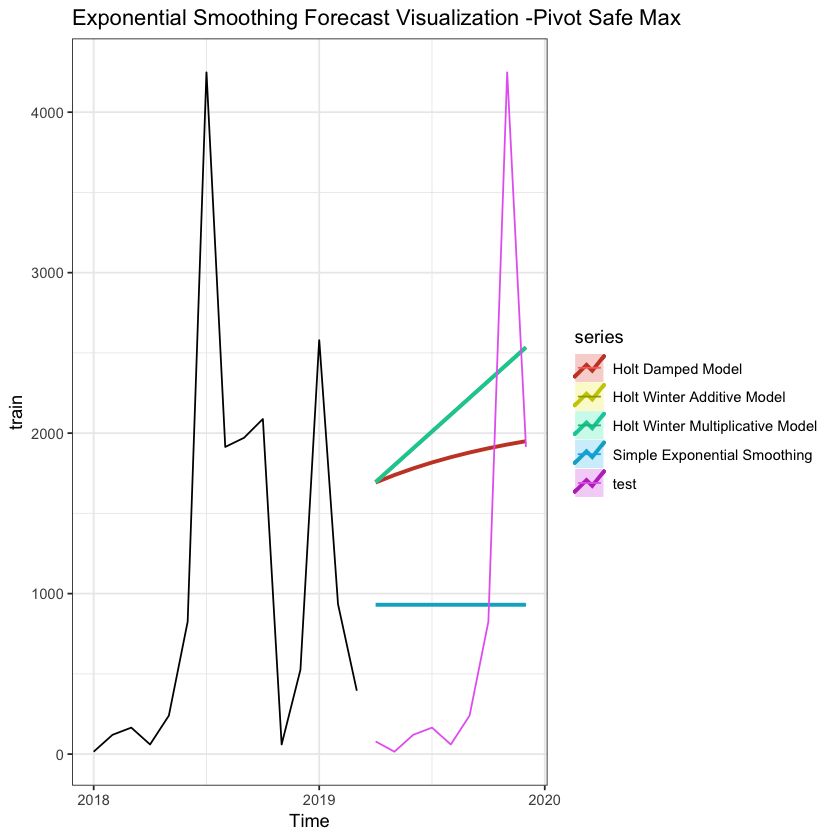

In [19]:
# Visualize forecasts (train & test)
autoplot(train)+
    autolayer(ses_model,series  = 'Simple Exponential Smoothing',PI = F, size = 1.1) +
    autolayer(holt_damp_model, series = 'Holt Damped Model', PI = F, size = 1.1)+
    autolayer(hw_additive, series = 'Holt Winter Additive Model', PI =F, size = 1.1)+
    autolayer(hw_multiplicative, series = 'Holt Winter Multiplicative Model', PI = F, size=1.1)+
labs(title="Exponential Smoothing Forecast Visualization -Pivot Safe Max")+
    autolayer(test)+theme_bw()

### Step8: Obtain the forecast Value

In [20]:
# obtain predicted value
ses_forecast = forecast(ses_model,h=9)
holt_forecast = forecast(holt_damp_model, h = 9)
hw_additive_forecast = forecast(hw_additive,h=9)
hw_multiplicative_forecast = forecast(hw_multiplicative,h=9)

In [21]:
ses_forecast

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Apr 2019       930.4731 -789.6554 2650.602 -1700.236 3561.183
May 2019       930.4731 -798.2346 2659.181 -1713.357 3574.303
Jun 2019       930.4731 -806.7715 2667.718 -1726.413 3587.359
Jul 2019       930.4731 -815.2666 2676.213 -1739.405 3600.352
Aug 2019       930.4731 -823.7206 2684.667 -1752.335 3613.281
Sep 2019       930.4731 -832.1341 2693.080 -1765.202 3626.148
Oct 2019       930.4731 -840.5075 2701.454 -1778.008 3638.954
Nov 2019       930.4731 -848.8416 2709.788 -1790.754 3651.700
Dec 2019       930.4731 -857.1368 2718.083 -1803.440 3664.387

In [22]:
holt_forecast

         Point Forecast      Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019       1692.515 -81.952284 3466.981 -1021.2983 4406.327
May 2019       1738.914 -35.553246 3513.381  -974.8993 4452.727
Jun 2019       1780.297   5.830202 3554.764  -933.5159 4494.110
Jul 2019       1817.207  42.740218 3591.674  -896.6059 4531.020
Aug 2019       1850.128  75.660354 3624.595  -863.6859 4563.941
Sep 2019       1879.489 105.021894 3653.957  -834.3244 4593.303
Oct 2019       1905.677 131.209504 3680.145  -808.1369 4619.491
Nov 2019       1929.034 154.566269 3703.502  -784.7803 4642.849
Dec 2019       1949.866 175.398190 3724.335  -763.9485 4663.681

In [23]:
hw_additive_forecast

         Point Forecast     Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019           1695  189.4355 3200.564 -607.56215 3997.562
May 2019           1800  294.4355 3305.564 -502.56215 4102.562
Jun 2019           1905  399.4355 3410.564 -397.56215 4207.562
Jul 2019           2010  504.4355 3515.564 -292.56215 4312.562
Aug 2019           2115  609.4355 3620.564 -187.56215 4417.562
Sep 2019           2220  714.4355 3725.564  -82.56215 4522.562
Oct 2019           2325  819.4355 3830.564   22.43785 4627.562
Nov 2019           2430  924.4355 3935.564  127.43785 4732.562
Dec 2019           2535 1029.4355 4040.564  232.43785 4837.562

In [24]:
hw_multiplicative_forecast

         Point Forecast     Lo 80    Hi 80      Lo 95    Hi 95
Apr 2019           1695  189.4355 3200.564 -607.56215 3997.562
May 2019           1800  294.4355 3305.564 -502.56215 4102.562
Jun 2019           1905  399.4355 3410.564 -397.56215 4207.562
Jul 2019           2010  504.4355 3515.564 -292.56215 4312.562
Aug 2019           2115  609.4355 3620.564 -187.56215 4417.562
Sep 2019           2220  714.4355 3725.564  -82.56215 4522.562
Oct 2019           2325  819.4355 3830.564   22.43785 4627.562
Nov 2019           2430  924.4355 3935.564  127.43785 4732.562
Dec 2019           2535 1029.4355 4040.564  232.43785 4837.562

### Step 9: Exponential Smoothing Model on the whole dataset

In [25]:
# Simple Exponential Smoothing Model on the whole dataset
library(forecast)
ses_model_all = ses(sales_ts,alpha=0.1, initial="simple")
ses_model_all

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Jan 2020         1042.7 -693.9094 2779.310 -1613.215 3698.616
Feb 2020         1042.7 -702.5708 2787.972 -1626.462 3711.863
Mar 2020         1042.7 -711.1895 2796.590 -1639.643 3725.044
Apr 2020         1042.7 -719.7661 2805.167 -1652.759 3738.160
May 2020         1042.7 -728.3010 2813.702 -1665.813 3751.214
Jun 2020         1042.7 -736.7951 2822.196 -1678.803 3764.204
Jul 2020         1042.7 -745.2488 2830.650 -1691.732 3777.133
Aug 2020         1042.7 -753.6627 2839.064 -1704.600 3790.001
Sep 2020         1042.7 -762.0374 2847.438 -1717.408 3802.809
Oct 2020         1042.7 -770.3735 2855.774 -1730.157 3815.558

In [26]:
# Holt's methods with damping on the whole dataset
holt_damp_model_all = holt(sales_ts,damped = T)
holt_damp_model_all

         Point Forecast      Lo 80    Hi 80      Lo 95    Hi 95
Jan 2020       2049.562  230.20702 3868.917  -732.9014 4832.026
Feb 2020       2055.287   69.12960 4041.444  -982.2784 5092.852
Mar 2020       2060.182  -79.86446 4200.229 -1212.7366 5333.101
Apr 2020       2064.368 -219.26027 4347.997 -1428.1402 5556.877
May 2020       2067.948 -350.78600 4486.682 -1631.1865 5767.083
Jun 2020       2071.010 -475.69882 4617.718 -1823.8448 5965.864
Jul 2020       2073.627 -594.94619 4742.201 -2007.6037 6154.859
Aug 2020       2075.866 -709.26295 4860.995 -2183.6212 6335.353
Sep 2020       2077.780 -819.23271 4974.794 -2352.8189 6508.380
Oct 2020       2079.418 -925.32835 5084.163 -2515.9448 6674.780

In [27]:
# Try to capture the seasonality, but not sufficient observations
# Holt - winter seasonal method
hw_additive_all = hw(sales_ts,seasonal = 'additive', damped = T)
hw_additive_all

         Point Forecast      Lo 80    Hi 80     Lo 95    Hi 95
Jan 2020     -313.41920 -3763.4636 3136.625 -5589.807 4962.968
Feb 2020       11.91299 -3438.1315 3461.957 -5264.475 5288.301
Mar 2020       59.40505 -3390.6396 3509.450 -5216.983 5335.793
Apr 2020      -42.99308 -3493.0380 3407.052 -5319.381 5233.395
May 2020      139.66113 -3310.3842 3589.706 -5136.728 5416.050
Jun 2020      727.42887 -2722.6170 4177.475 -4548.961 6003.819
Jul 2020     4152.87644   702.8298 7602.923 -1123.515 9429.267
Aug 2020     1822.09589 -1627.9517 5272.143 -3454.297 7098.488
Sep 2020     1882.04661 -1568.0021 5332.095 -3394.348 7158.441
Oct 2020     2002.09948 -1447.9507 5452.150 -3274.297 7278.496
Nov 2020      299.96593 -3150.0859 3750.018 -4976.433 5576.365
Dec 2020      445.48344 -3004.5704 3895.537 -4830.919 5721.885
Jan 2021     -351.26353 -3801.3200 3098.793 -5627.670 4925.143
Feb 2021      -25.13135 -3475.1904 3424.928 -5301.541 5251.279
Mar 2021       23.14379 -3426.9182 3473.206 -5253.271 5

In [28]:
# Holt - winter Multiplicative
hw_multiplicative_all =  hw(sales_ts,seasonal = 'multiplicative', damped = T)
hw_multiplicative_all

         Point Forecast         Lo 80        Hi 80         Lo 95        Hi 95
Jan 2020     2830.12180   -281350.847   287011.091   -431787.165   437447.408
Feb 2020     1021.22630   -101535.427   103577.880   -155825.640   157868.093
Mar 2020      447.49054    -44503.276    45398.257    -68298.774    69193.755
Apr 2020       93.42696     -9295.455     9482.309    -14265.628    14452.482
May 2020       51.31711     -5109.093     5211.727     -7840.849     7943.484
Jun 2020      251.67536    -25079.040    25582.390    -38488.310    38991.661
Jul 2020      821.54082    -81960.371    83603.453   -125782.468   127425.550
Aug 2020      359.32750    -35900.000    36618.655    -55094.528    55813.183
Sep 2020      564.99320    -56546.825    57676.812    -86779.995    87909.982
Oct 2020     1213.10221   -121663.686   124089.890   -186710.728   189136.932
Nov 2020     4547.04344   -457123.267   466217.354   -701516.767   710610.853
Dec 2020     2106.39749   -212339.474   216552.269   -325860.261

### Step10: Model Forecast Visualization on the whole dataset

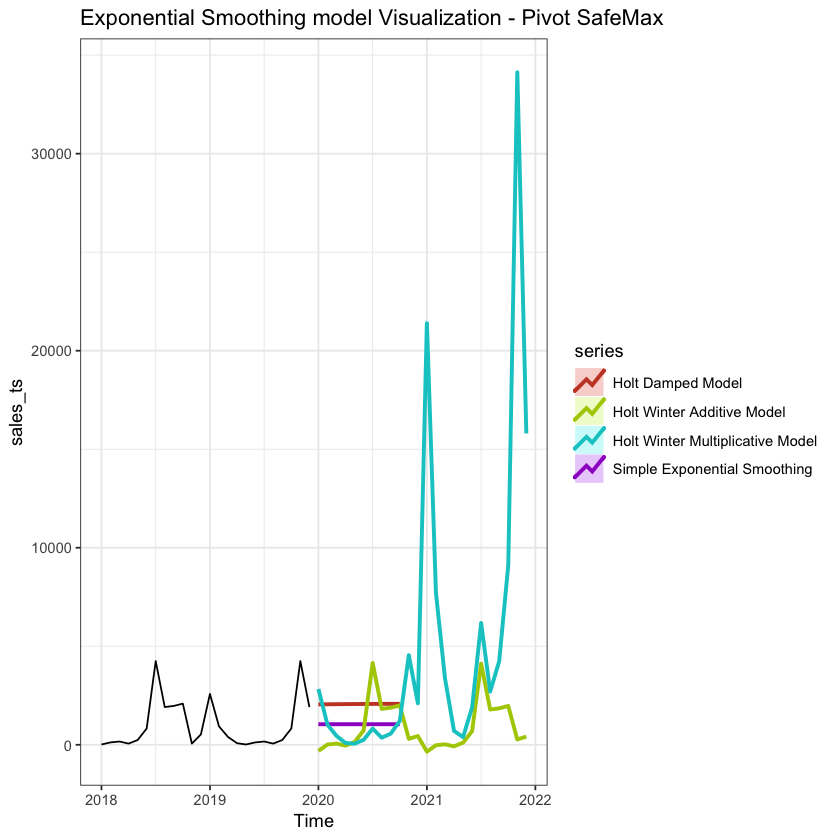

In [29]:
# Visualize forecasts (train & test)
autoplot(sales_ts)+
    autolayer(ses_model_all,series  = 'Simple Exponential Smoothing',PI = F, size = 1.1) +
    autolayer(holt_damp_model_all, series = 'Holt Damped Model', PI = F, size = 1.1)+
    autolayer(hw_additive_all, series = 'Holt Winter Additive Model', PI =F, size = 1.1)+
    autolayer(hw_multiplicative_all, series = 'Holt Winter Multiplicative Model', PI = F, size=1.1)+
labs(title="Exponential Smoothing model Visualization - Pivot SafeMax")+theme_bw()

### Step10: obtain forecast values on the whole dataset

In [43]:
# obtain predicted value
ses_forecast_all = forecast(ses_model_all)
holt_forecast_all = forecast(holt_damp_model_all)
hw_additive_forecast_all = forecast(hw_additive_all)
hw_multiplicative_forecast_all = forecast(hw_multiplicative_all)

In [44]:
ses_forecast_all

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Jan 2020         1042.7 -693.9094 2779.310 -1613.215 3698.616
Feb 2020         1042.7 -702.5708 2787.972 -1626.462 3711.863
Mar 2020         1042.7 -711.1895 2796.590 -1639.643 3725.044
Apr 2020         1042.7 -719.7661 2805.167 -1652.759 3738.160
May 2020         1042.7 -728.3010 2813.702 -1665.813 3751.214
Jun 2020         1042.7 -736.7951 2822.196 -1678.803 3764.204
Jul 2020         1042.7 -745.2488 2830.650 -1691.732 3777.133
Aug 2020         1042.7 -753.6627 2839.064 -1704.600 3790.001
Sep 2020         1042.7 -762.0374 2847.438 -1717.408 3802.809
Oct 2020         1042.7 -770.3735 2855.774 -1730.157 3815.558

In [45]:
holt_forecast_all

         Point Forecast      Lo 80    Hi 80      Lo 95    Hi 95
Jan 2020       2049.562  230.20702 3868.917  -732.9014 4832.026
Feb 2020       2055.287   69.12960 4041.444  -982.2784 5092.852
Mar 2020       2060.182  -79.86446 4200.229 -1212.7366 5333.101
Apr 2020       2064.368 -219.26027 4347.997 -1428.1402 5556.877
May 2020       2067.948 -350.78600 4486.682 -1631.1865 5767.083
Jun 2020       2071.010 -475.69882 4617.718 -1823.8448 5965.864
Jul 2020       2073.627 -594.94619 4742.201 -2007.6037 6154.859
Aug 2020       2075.866 -709.26295 4860.995 -2183.6212 6335.353
Sep 2020       2077.780 -819.23271 4974.794 -2352.8189 6508.380
Oct 2020       2079.418 -925.32835 5084.163 -2515.9448 6674.780

In [46]:
hw_additive_forecast_all

         Point Forecast      Lo 80    Hi 80     Lo 95    Hi 95
Jan 2020     -313.41920 -3763.4636 3136.625 -5589.807 4962.968
Feb 2020       11.91299 -3438.1315 3461.957 -5264.475 5288.301
Mar 2020       59.40505 -3390.6396 3509.450 -5216.983 5335.793
Apr 2020      -42.99308 -3493.0380 3407.052 -5319.381 5233.395
May 2020      139.66113 -3310.3842 3589.706 -5136.728 5416.050
Jun 2020      727.42887 -2722.6170 4177.475 -4548.961 6003.819
Jul 2020     4152.87644   702.8298 7602.923 -1123.515 9429.267
Aug 2020     1822.09589 -1627.9517 5272.143 -3454.297 7098.488
Sep 2020     1882.04661 -1568.0021 5332.095 -3394.348 7158.441
Oct 2020     2002.09948 -1447.9507 5452.150 -3274.297 7278.496
Nov 2020      299.96593 -3150.0859 3750.018 -4976.433 5576.365
Dec 2020      445.48344 -3004.5704 3895.537 -4830.919 5721.885
Jan 2021     -351.26353 -3801.3200 3098.793 -5627.670 4925.143
Feb 2021      -25.13135 -3475.1904 3424.928 -5301.541 5251.279
Mar 2021       23.14379 -3426.9182 3473.206 -5253.271 5

In [47]:
hw_multiplicative_forecast_all

         Point Forecast         Lo 80        Hi 80         Lo 95        Hi 95
Jan 2020     2830.12180   -281350.847   287011.091   -431787.165   437447.408
Feb 2020     1021.22630   -101535.427   103577.880   -155825.640   157868.093
Mar 2020      447.49054    -44503.276    45398.257    -68298.774    69193.755
Apr 2020       93.42696     -9295.455     9482.309    -14265.628    14452.482
May 2020       51.31711     -5109.093     5211.727     -7840.849     7943.484
Jun 2020      251.67536    -25079.040    25582.390    -38488.310    38991.661
Jul 2020      821.54082    -81960.371    83603.453   -125782.468   127425.550
Aug 2020      359.32750    -35900.000    36618.655    -55094.528    55813.183
Sep 2020      564.99320    -56546.825    57676.812    -86779.995    87909.982
Oct 2020     1213.10221   -121663.686   124089.890   -186710.728   189136.932
Nov 2020     4547.04344   -457123.267   466217.354   -701516.767   710610.853
Dec 2020     2106.39749   -212339.474   216552.269   -325860.261

### Step 11: obtain the accuracy value for the constructed models

In [48]:
# ses model
ses_accuracy = accuracy(ses_forecast,x=sales_ts) # accuracy on train and test sets
ses_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,610.31541,1342.223,859.1893,-62.96356,162.1769,0.7144035,0.2104424,NA
Test set,-78.69533,1334.367,1034.4851,-1104.67485,1133.4487,0.8601594,0.3959335,6.290666


In [49]:
# holt damped model
holt_damped_accuracy = accuracy(holt_forecast, x= sales_ts)
holt_damped_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,163.1831,1130.541,816.8999,-85.26975,384.6766,0.6792405,0.1743306,NA
Test set,-986.3475,1615.925,1501.6732,-2185.00467,2197.1357,1.2486196,0.3635177,12.92544


In [50]:
# hw_additive
hw_additive_accuracy = accuracy(hw_additive_forecast, x = sales_ts)
hw_additive_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,220.9333,1174.798,841.7333,-245.7074,286.5435,0.6998891,0.2160715,NA
Test set,-1263.2222,1715.036,1667.2222,-2330.3020,2339.8124,1.3862712,0.2648131,13.99766


In [51]:
# hw_multiplicative
hw_multiplicative_accuracy = accuracy(hw_multiplicative_forecast, x = sales_ts)
hw_multiplicative_accuracy

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,220.9333,1174.798,841.7333,-245.7074,286.5435,0.6998891,0.2160715,NA
Test set,-1263.2222,1715.036,1667.2222,-2330.3020,2339.8124,1.3862712,0.2648131,13.99766
